In [1]:
import sys
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
#from tensorflow import keras
#to not use the gpu
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import keras
import flopy
import pyemu

Using TensorFlow backend.


In [2]:
npar = 200
nrow,ncol = 80,50

In [3]:
gen_name = "gen_88.h5"
gen_d = "."
generator = keras.models.load_model(os.path.join(gen_d,gen_name))

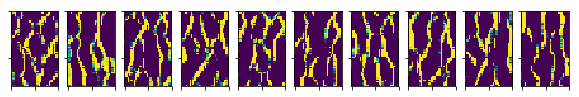

In [4]:
np.random.seed = 1123445
truths = np.random.randn(10,npar)
truth_vecs = generator.predict(truths)
fig, axes = plt.subplots(nrows=1,ncols=10,figsize = (10,10))
for ax,vec in zip(axes.flatten(),truth_vecs.reshape(10,nrow,ncol)):
    ax.imshow(vec)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    

### mod the existing pest interface to use the gan par scheme

In [6]:
model_ws = "temp_gan1"
if os.path.exists(model_ws):
    shutil.rmtree(model_ws)
shutil.copytree("template_grid_ies",model_ws)
#os.remove(os.path.join(model_ws,"prior.jcb"))

'temp_gan1'

In [7]:
with open(os.path.join(model_ws,"par.dat.tpl"),'w') as f:
    f.write("ptf ~\n")
    [f.write("~ par_{0:03d}   ~\n".format(ipar)) for ipar in range(npar)]
with open(os.path.join(model_ws,"par.dat"),'w') as f:
    [f.write("{0:15.6E}\n".format(ipar)) for ipar in truths[4,:]]

prep the forward run call

In [8]:
with open(os.path.join(model_ws,"apply_gan.py"),'w') as f:
    f.write("import os\n")
    f.write("os.environ['CUDA_VISIBLE_DEVICES'] = '-1'\n")
    f.write("import numpy as np\nimport keras\n")
    f.write("def apply():\n")
    f.write("    gen = keras.models.load_model('{0}')\n".format(gen_name))
    f.write("    vals = np.atleast_2d(np.loadtxt('par.dat'))\n") 
    f.write("    print(vals.shape)\n")
    f.write("    vec = gen.predict(vals).reshape({0},{1})\n".format(nrow,ncol))
    f.write("    np.savetxt('hk.ref',10**vec)\n")
    f.write("    return vec\n")
    f.write("if __name__ == '__main__':\n")
    f.write("    apply()\n")
shutil.copy2(os.path.join(gen_d,gen_name),os.path.join(model_ws,gen_name))  
bat_file = os.path.join(model_ws,"model.bat")
with open(bat_file,'r') as f:
    lines = f.readlines()
lines.insert(0,"python apply_gan.py\n")
with open(bat_file,'w') as f:
    [f.write(line) for line in lines]
    

(1, 200)


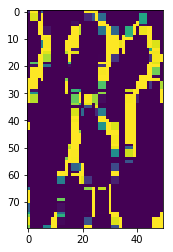

In [9]:
bd = os.getcwd()
try:
    
    os.chdir(model_ws)
    import apply_gan
    import importlib # incase apply_gan.py has changed...
    importlib.reload(apply_gan)
    hk = apply_gan.apply()
except Exception as e:
    print(str(e))
    os.chdir(bd)

os.chdir(bd)

ax1 = plt.subplot(121)
ax1.imshow(hk)
plt.show()

Mod the pest control file

In [17]:
pst = pyemu.Pst(os.path.join(model_ws,"new.pst"))
pst.pestpp_options = {}
pst.template_files = ["wel.dat.tpl","par.dat.tpl"]
pst.input_files = ["wel.dat","par.dat"]
par = pst.parameter_data
not_par = par.loc[par.parnme.apply(lambda x: not x.startswith("gr")),"parnme"]
pst.parameter_data = par.loc[not_par,:]
pst.parameter_data.loc[:,"pargp"] = 'welflux'
df = pst.add_parameters(os.path.join(model_ws,"par.dat.tpl"),os.path.join(model_ws,"par.dat"),pst_path=".")
par = pst.parameter_data
par.loc[df.parnme,"partrans"] = "none"
par.loc[df.parnme,"parubnd"] = 4.0
par.loc[df.parnme,"parlbnd"] = -4.0
par.loc[df.parnme,"parval1"] = 0.0
par.loc[df.parnme,"pargp"] = "gan"
par.sort_values(by="parnme",inplace=True)


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


Make a new instruction file to track the hk values

In [18]:
ins_file = os.path.join(model_ws,"hk.ref.ins")
with open(ins_file,'w') as f:
    f.write("pif ~\n")
    for i in range(nrow):
        f.write("l1 ")
        for j in range(ncol):
            oname = "hk_{0:03d}_{1:03d}".format(i,j)
            f.write(" !{0}!".format(oname))
        f.write("\n")
df = pst.add_observations(ins_file,ins_file.replace(".ins",""),pst_path='.')
pst.observation_data.loc[df.obsnme,"weight"] = 0.0

error using inschek for instruction file .\hk.ref.ins:run() returned non-zero
observations in this instruction file will havegeneric values.


In [19]:
pst.control_data.noptmax = 0
pst.write(os.path.join(model_ws,"new_gan.pst"))
pyemu.os_utils.run("pestpp new_gan.pst",cwd=model_ws)

noptmax: 0


Run a sweep

In [20]:
pst.control_data.noptmax = -1
pst.pestpp_options = {"ies_num_reals":500,"par_sigma_range":8.0}
pst.write(os.path.join(model_ws,"new_gan.pst"))
m_d = "master_gan_sweep"
pyemu.os_utils.start_slaves(model_ws,"pestpp-ies","new_gan.pst",num_slaves=10,port=4020,master_dir=m_d)

noptmax: -1


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


274

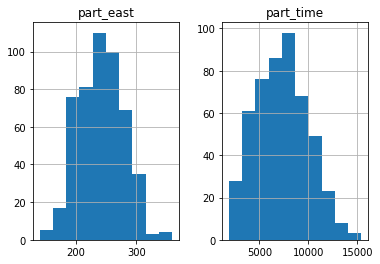

In [21]:
oe = pd.read_csv(os.path.join(m_d,"new_gan.0.obs.csv"))
oe.columns = oe.columns.str.lower()
pe = pd.read_csv(os.path.join(m_d,"new_gan.0.par.csv"))
pe.columns = pe.columns.str.lower()

oe.loc[:,["part_time","part_east"]].hist()
oe.loc[oe.part_east==oe.part_east.min(),["part_time","part_east"]]
truth_real = oe.loc[oe.part_east==oe.part_east.min(),"real_name"].astype(int).values[0]
truth_real

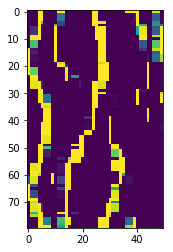

In [22]:
obs = pst.observation_data
hk_obs = obs.loc[obs.obsnme.apply(lambda x: x.startswith("hk")),["obsnme"]]
hk_obs.loc[:,'i'] = hk_obs.obsnme.apply(lambda x: int(x.split('_')[1]))
hk_obs.loc[:,'j'] = hk_obs.obsnme.apply(lambda x: int(x.split('_')[2]))
arr = np.zeros((nrow,ncol))
arr[hk_obs.i,hk_obs.j] = oe.loc[truth_real,hk_obs.obsnme]
plt.imshow(arr)
truth_arr = arr

In [23]:
pst = pyemu.Pst(os.path.join(model_ws,"new_gan.pst"))
oe.index = oe.real_name
pe.index = pe.real_name
pst.parameter_data.loc[:,"parval1"] = pe.loc[str(truth_real),pst.par_names]
pst.observation_data.loc[:,"obsval"] = oe.loc[str(truth_real),pst.obs_names]
pst.control_data.noptmax = 0
pst.write(os.path.join(model_ws,"new_gan_truth.pst"))
pyemu.os_utils.run("pestpp new_gan_truth.pst",cwd=model_ws)

noptmax: 0


5.22800000034184e-09

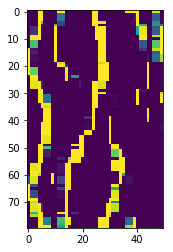

In [24]:
pst = pyemu.Pst(os.path.join(model_ws,"new_gan_truth.pst"))
arr = np.zeros((nrow,ncol))
arr[hk_obs.i,hk_obs.j] = pst.res.loc[hk_obs.obsnme,"modelled"]
plt.imshow(arr)
pst.phi

now for some ies fun...

In [25]:
par = pst.parameter_data
par.loc[par.pargp=="gan","parval1"] = 0.0 #so the base real doesn't fit perfectly
pst.pestpp_options = {}
pst.pestpp_options["par_sigma_range"] = 8.0
pst.pestpp_options["ies_num_reals"] = 50
pst.pestpp_options["ies_lambda_mults"] = [0.1,1.0,2.0]
pst.pestpp_options["lambda_scale_fac"] = [0.5,0.75,1.0]
pst.control_data.noptmax = 6
pst.write(os.path.join(model_ws,"new_gan_ies.pst"))

noptmax: 6


In [26]:
m_d = "master_gan_ies"
pyemu.os_utils.start_slaves(model_ws,"pestpp-ies","new_gan_ies.pst",num_slaves=10,master_dir=m_d)

In [27]:
pst = pyemu.Pst(os.path.join(model_ws,"new_gan_ies.pst"))

In [28]:
obs_en_names = [f for f in os.listdir(m_d) if f.endswith(".obs.csv") and "base" not in f and "mean" not in f]
obs_en = [pd.read_csv(os.path.join(m_d,f)) for f in obs_en_names]
len(obs_en)

7

In [29]:
obs = pst.observation_data
hk_obs = obs.loc[obs.obsnme.apply(lambda x: x.startswith("hk")),:].copy()
hk_obs.loc[:,"i"] = hk_obs.obsnme.apply(lambda x: int(x.split('_')[1]))
hk_obs.loc[:,"j"] = hk_obs.obsnme.apply(lambda x: int(x.split('_')[2]))

In [30]:
plt.close("all")
with PdfPages(os.path.join(m_d,"iter_compare.pdf")) as pdf:

    plt_rows = len(obs_en)
    fig,axes = plt.subplots(nrows=plt_rows,ncols=12,figsize=(10,10),subplot_kw={"aspect":"equal"})
    print(axes.shape,len(obs_en))
    for i,oe in enumerate(obs_en):
        print(obs_en_names[i])
        oe.columns = oe.columns.str.lower()
        phi_vector = pyemu.ObservationEnsemble.from_dataframe(df=oe,pst=pst).phi_vector
        ax = axes[i,1]
        ax.imshow(truth_arr)
        ax.set_title("truth")
        for j,idx in enumerate(oe.index[:10]):
            ax = axes[i,j+2]
            arr = np.zeros((nrow,ncol))
            arr[hk_obs.i,hk_obs.j] = oe.loc[idx,hk_obs.obsnme]
            ax.imshow(arr)#,vmax = truth_vec.max(),vmin=truth_vec.min())
            ax.set_title("{0:5.1f}".format(phi_vector[j]))
        ax = axes[i,0]
        for oname in pst.nnz_obs_names:
            oval = pst.observation_data.loc[oname,"obsval"]
            [ax.plot([oval,oval],[oe.loc[:,oname].min(),oe.loc[:,oname].max()],"b-",alpha=0.5)]
        xlim = ax.get_xlim()
        ax.set_ylim(*xlim)
        ax.plot([xlim[0],xlim[1]],[xlim[0],xlim[1]],"k--",lw=2.0)
        ax.set_title("iter {0}".format(i))


    for ax in axes.flatten():
       ax.set_xticklabels([])
       ax.set_yticklabels([])
    pdf.savefig()
plt.close(fig)

(7, 12) 7
new_gan_ies.0.obs.csv
new_gan_ies.1.obs.csv
new_gan_ies.2.obs.csv
new_gan_ies.3.obs.csv
new_gan_ies.4.obs.csv
new_gan_ies.5.obs.csv
new_gan_ies.6.obs.csv


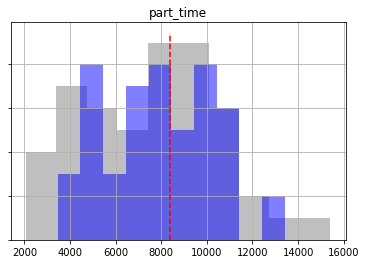

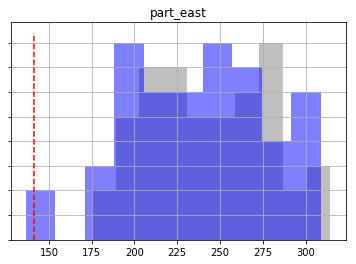

In [42]:
fnames = ["part_time","part_east"]
for name in fnames:
    fig,ax = plt.subplots()
    truth = obs.loc[name,"obsval"]
    obs_en[0].loc[:,name].hist(ax=ax,facecolor="0.5",edgecolor=None,alpha=0.5)
    obs_en[-1].loc[:,name].hist(ax=ax,facecolor="b",edgecolor=None,alpha=0.5)
    ylim = ax.get_ylim()
    ax.plot([truth,truth],ylim,"r--")
    ax.set_yticklabels([])
    ax.set_title(name)
plt.savefig(os.path.join(m_d,"forecasts.pdf"))
plt.show()